[Paper](https://openreview.net/pdf?id=B17JTOe0-)

In [ ]:
 import keras 
from keras import regularizers
from keras.layers import SimpleRNN, Dense, GaussianNoise
from keras.models import Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
 
from google.colab import drive
drive.mount('/content/gdrive')
 
dir = '/content/gdrive/My Drive/btp'
images_dir = '/content/gdrive/My Drive/btp/Images'

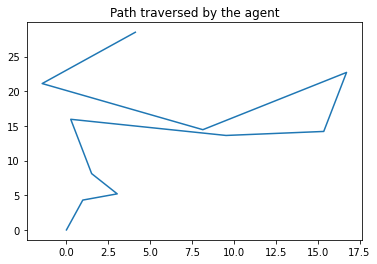

In [ ]:
def generate_input(path):
  
  input = []
  state = [0, 0]  
  for next_state in path:
    delta_y = next_state[1]-state[1]
    delta_x = next_state[0]-state[0]
    speed = ((delta_y)**2 + (delta_x)**2)**0.5
    direction = np.arctan2(delta_y,delta_x)
    input.append([speed,direction])
    state = next_state
  
  return input

N = 100000 # Number of data samples
max_step = 10
steps = 10
boundary = 50

input_set = []
output_set = []

np.random.seed(0)

for i in range(N):

  path = []
  for x in range(steps): 
    delta = list(np.random.uniform(-max_step,max_step,2))
    if x==0: path.append(delta)
    else: 
      while(True):
        a = path[x-1][0]+delta[0]
        b = path[x-1][1]+delta[1]
        if abs(a)<boundary and abs(b)<boundary:
          path.append([a,b])
          break
        delta = list(np.random.uniform(-max_step,max_step,2))
      # path.append([max(min(path[x-1][0]+delta[0],boundary),-boundary),max(min(path[x-1][1]+delta[1],boundary),-boundary)])

  input = generate_input(path)
  
  input_set.append(input)
  output_set.append(path)

plt.plot([0]+[state[0] for state in output_set[0]], [0]+[state[1] for state in output_set[0]])
plt.title('Path traversed by the agent')
plt.show()


In [4]:
np_input = np.array(input_set)
np_output = np.array(output_set)

for x in range(2):
    temp = np_input[:,:,x]
    min = np.min(temp)
    # max = np.max(temp)
    np_input[:,:,x] = (temp-min)

for x in range(2):
    temp = np_output[:,:,x]
    min = np.min(temp)
    # max = np.max(temp)
    np_output[:,:,x] = (temp-min)

input_set = np_input.tolist()
output_set = np_output.tolist()

np.save('/content/gdrive/My Drive/BTP/input_set', np_input)

In [6]:
model = Sequential()

model.add(SimpleRNN(100, activation='relu', input_shape=(steps,2), return_sequences=True, recurrent_regularizer='l2', activity_regularizer='l2'))
model.add(GaussianNoise(0.1))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse')

# model.summary()

In [7]:
xtrain = input_set[:int(0.8*len(input_set))]
ytrain = output_set[:int(0.8*len(output_set))]
xtest = input_set[int(0.8*len(input_set)):]
ytest = output_set[int(0.8*len(output_set)):]

In [8]:
batch_size = 200
epochs = 50

model.summary()
model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(xtest, ytest))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 100)           10300     
_________________________________________________________________
gaussian_noise (GaussianNois (None, 10, 100)           0         
_________________________________________________________________
dense (Dense)                (None, 10, 2)             202       
Total params: 10,502
Trainable params: 10,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
400/400 [==============================] - 32s 27ms/step - loss: 747.3242 - val_loss: 232.2795
Epoch 2/50
400/400 [==============================] - 6s 14ms/step - loss: 225.8364 - val_loss: 176.2260
Epoch 3/50
400/400 [==============================] - 5s 14ms/step - loss: 179.9854 - val_loss: 180.6134
Epoch 4/50
400/400 [==============================] - 5s 14ms/step

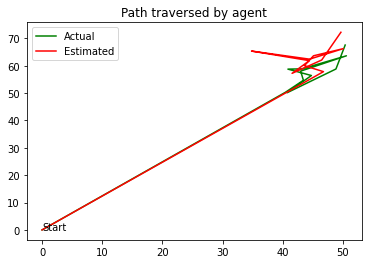

In [9]:
instruction = xtest[-100]
path = ytest[-100]

estimate = model.predict([instruction])

plt.plot([0]+[state[0] for state in path], [0]+[state[1] for state in path], 'g')
plt.plot([0]+[state[0] for state in estimate[0]], [0]+[state[1] for state in estimate[0]], 'r')
plt.legend(['Actual', 'Estimated'])
plt.annotate('Start', (0,0))
plt.title("Path traversed by agent")
# plt.savefig(f"{images_dir}/path.png")
plt.show()

In [ ]:
weights = model.layers[0].get_weights()
model.save(f'{dir}/model_rect_{boundary}_{steps}.h5')

model2 = Sequential()
model2.add(SimpleRNN(100, input_shape=(steps,2), return_sequences=True, weights=weights))

In [ ]:
firing = {}
for h in range(100):
  firing[h] = {}

for instruction in xtest:
  estimate = model.predict([instruction])[0]
  representation = model2.predict([instruction])[0]
  for h in range(100):
    for i in range(steps):
      firing[h][tuple(estimate[i])] = representation[i][h]

KeyboardInterrupt: ignored

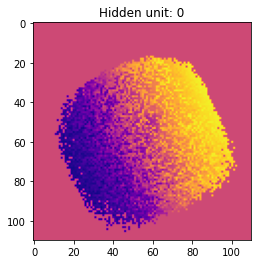

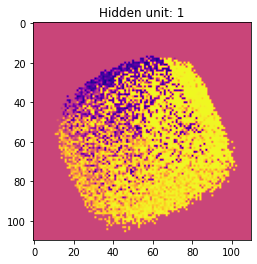

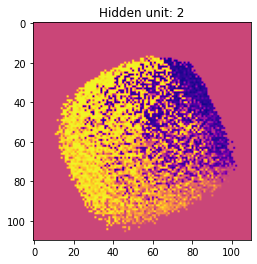

KeyboardInterrupt: ignored

In [ ]:
def heatmap2d(arr: np.ndarray, h):
    plt.imshow(arr, cmap='plasma')
    # plt.colorbar()
    plt.title(f'Hidden unit: {h}')
    # plt.savefig(f"{images_dir}/rect/{h}.png")
    plt.show()


for h in range(100):
  arr = np.zeros((int(boundary*2.2),int(boundary*2.2)))
  # arr = -100*arr
  for key in firing[h].keys():
    arr[int(key[0]+boundary*1.1)][int(key[1]+boundary*1.1)] = firing[h][key]*10
  heatmap2d(arr, h)

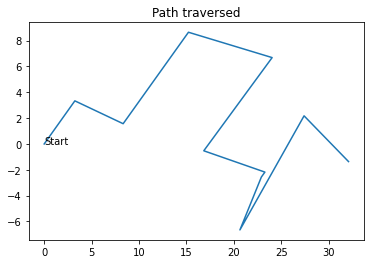

In [ ]:

plt.plot([0]+[state[0] for state in output_set[0]], [0]+[state[1] for state in output_set[0]])
plt.title('Path traversed')
# plt.xlim([-50,50])
# plt.ylim([-50,50])
plt.annotate('Start', (0,0))
plt.show()